This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to Keras and TensorFlow

## What's TensorFlow?

## What's Keras?

## Keras and TensorFlow: A brief history

## Setting up a deep-learning workspace

### Jupyter notebooks: The preferred way to run deep-learning experiments

### Using Colaboratory

#### First steps with Colaboratory

#### Installing packages with pip

#### Using the GPU runtime

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [1]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [2]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Random tensors**

In [3]:
# 均值为0、标准差为1的正态分布
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.7782032 ]
 [ 0.80403346]
 [-1.2195541 ]], shape=(3, 1), dtype=float32)


In [4]:
# 0到1之间的均匀分布
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.30223393]
 [0.06057477]
 [0.12015617]], shape=(3, 1), dtype=float32)


**NumPy arrays are assignable**

In [5]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

**Creating a TensorFlow variable**

In [6]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.43808508],
       [-0.6895598 ],
       [ 0.05901159]], dtype=float32)>


**Assigning a value to a TensorFlow variable**

In [7]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Assigning a value to a subset of a TensorFlow variable**

In [8]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Using `assign_add`**

In [9]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [10]:
a = tf.ones((2, 2))
# 求平方
b = tf.square(a)
# 求平方根
c = tf.sqrt(a)
d = b + c
# 计算两个张量的积
e = tf.matmul(a, b)
e *= d

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [11]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
    result = tf.square(input_var)
# 检索模型损失相对于权重的梯度    
gradient = tape.gradient(result, input_var)

**Using `GradientTape` with constant tensor inputs**

In [12]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
    # 监视常数张量
    tape.watch(input_const)
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

**Using nested gradient tapes to compute second-order gradients**

In [13]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
print(acceleration)

tf.Tensor(9.8, shape=(), dtype=float32)


#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [14]:
num_samples_per_class = 1000
# cov协方差矩阵描述了点云的形状，均值描述了点云在平面上的位置
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [15]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [16]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

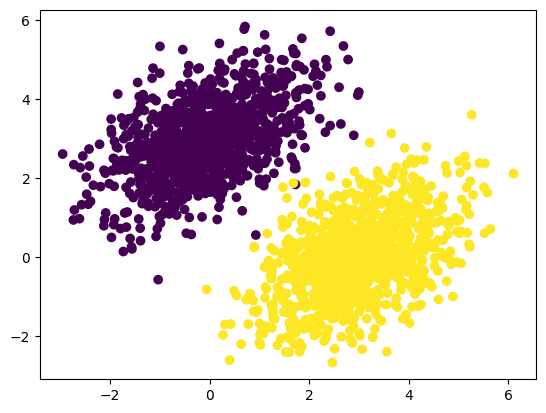

In [17]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [18]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [19]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [20]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    # 将每个样本的损失值平均为一个标量损失值
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [21]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        # 在一次梯度带作用域内进行一次前向传播
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    # 检索损失相对于权重的梯度
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # 更新权重
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [22]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 3.1240
Loss at step 1: 0.3430
Loss at step 2: 0.1479
Loss at step 3: 0.1196
Loss at step 4: 0.1096
Loss at step 5: 0.1021
Loss at step 6: 0.0955
Loss at step 7: 0.0894
Loss at step 8: 0.0839
Loss at step 9: 0.0788
Loss at step 10: 0.0742
Loss at step 11: 0.0700
Loss at step 12: 0.0662
Loss at step 13: 0.0627
Loss at step 14: 0.0595
Loss at step 15: 0.0565
Loss at step 16: 0.0538
Loss at step 17: 0.0514
Loss at step 18: 0.0492
Loss at step 19: 0.0471
Loss at step 20: 0.0453
Loss at step 21: 0.0436
Loss at step 22: 0.0420
Loss at step 23: 0.0406
Loss at step 24: 0.0393
Loss at step 25: 0.0381
Loss at step 26: 0.0371
Loss at step 27: 0.0361
Loss at step 28: 0.0352
Loss at step 29: 0.0343
Loss at step 30: 0.0336
Loss at step 31: 0.0329
Loss at step 32: 0.0323
Loss at step 33: 0.0317
Loss at step 34: 0.0312
Loss at step 35: 0.0307
Loss at step 36: 0.0303
Loss at step 37: 0.0299
Loss at step 38: 0.0295
Loss at step 39: 0.0292


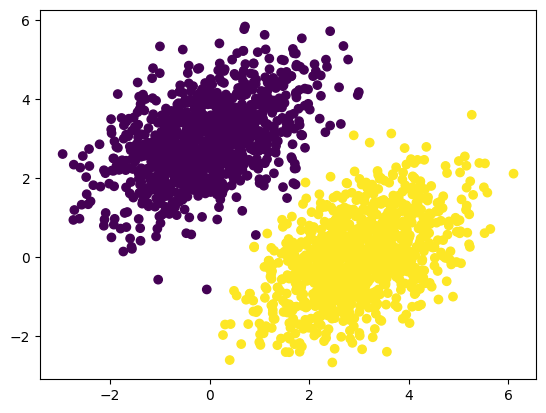

In [23]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

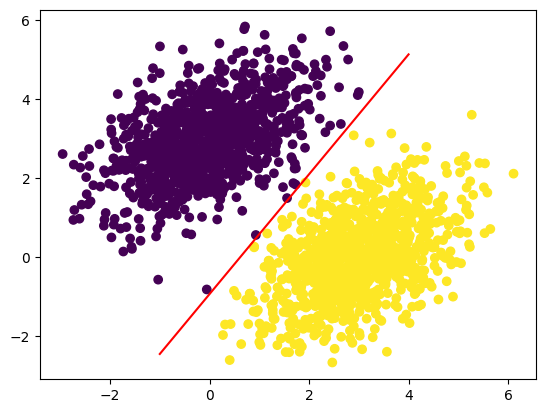

In [24]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [25]:
from tensorflow import keras


class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # 使用add_weight方法快速创建权重
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")
    # 定义前向传播计算
    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [26]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


#### Automatic shape inference: Building layers on the fly

In [27]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [28]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [29]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [30]:
# 定义一个线性分类器
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [31]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [32]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 [==============================] - 0s 3ms/step - loss: 0.3204 - binary_accuracy: 0.4775
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 0.2648 - binary_accuracy: 0.5755
Epoch 3/5
16/16 [==============================] - 0s 3ms/step - loss: 0.2228 - binary_accuracy: 0.6565
Epoch 4/5
16/16 [==============================] - 0s 3ms/step - loss: 0.1870 - binary_accuracy: 0.7180
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 0.1565 - binary_accuracy: 0.7750


In [33]:
history.history

{'loss': [0.3203549385070801,
  0.2647537887096405,
  0.22279925644397736,
  0.18695375323295593,
  0.15645693242549896],
 'binary_accuracy': [0.47749999165534973,
  0.5755000114440918,
  0.656499981880188,
  0.7179999947547913,
  0.7749999761581421]}

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [34]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

# 随机索引排列将数据打乱
indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

# 保留30%的训练数据用于验证
num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 [==============================] - 1s 5ms/step - loss: 0.1903 - binary_accuracy: 0.9129 - val_loss: 0.1142 - val_binary_accuracy: 0.9417
Epoch 2/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0740 - binary_accuracy: 0.9586 - val_loss: 0.0303 - val_binary_accuracy: 0.9967
Epoch 3/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0708 - binary_accuracy: 0.9593 - val_loss: 0.0328 - val_binary_accuracy: 0.9967
Epoch 4/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0753 - binary_accuracy: 0.9514 - val_loss: 0.0735 - val_binary_accuracy: 0.9967
Epoch 5/5
88/88 [==============================] - 0s 3ms/step - loss: 0.0697 - binary_accuracy: 0.9493 - val_loss: 0.1681 - val_binary_accuracy: 0.6917


### Inference: Using a model after training

In [35]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 [==============================] - 0s 2ms/step
[[ 0.459239  ]
 [ 0.4425075 ]
 [ 0.788269  ]
 [-0.01690173]
 [ 0.21061711]
 [ 0.74293375]
 [ 0.41024476]
 [ 0.7859645 ]
 [ 0.17310935]
 [-0.18479034]]


## Summary